APPLYING MLP ON CICIDS 2018 DATASET


Name- Ayush Saini

**CODE**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# =====================
# 1. Load CICIDS 2018 dataset
# =====================
from google.colab import drive
drive.mount('/content/drive')

files = [
    "/content/drive/MyDrive/LAB_CICIDS 2018_1.csv"
]

import pandas as pd

df_list = [pd.read_csv(f, low_memory=False) for f in files]
cicids_df = pd.concat(df_list, ignore_index=True)

print("Dataset shape:", cicids_df.shape)
print("Columns:", cicids_df.columns[:10])

# Drop irrelevant columns (adjust depending on actual CSVs)
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
cicids_df = cicids_df.drop(columns=[c for c in drop_cols if c in cicids_df.columns])

# Features & Labels
X = cicids_df.drop("Label", axis=1)
y = cicids_df["Label"]

# Convert all columns to numeric, coercing errors
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
X.dropna(inplace=True)
y = y[X.index] # Align y with the cleaned X

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1049)#random state as my registration number

print("Train:", X_train.shape, "Test:", X_test.shape, "Classes:", len(le.classes_))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (248528, 80)
Columns: Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min'],
      dtype='object')
Train: (197929, 78) Test: (49483, 78) Classes: 14


In [ ]:
#MLP (ReLU + Softmax)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, int(val)] = 1
    return ary

class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        rng = np.random.RandomState(random_seed)
        self.num_classes = num_classes

        # hidden layer params
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output layer params
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = relu(z_h)

        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = softmax(z_out)

        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)
        delta_out = (a_out - y_onehot) / y.shape[0]

        # output grads
        d_loss__dw_out = np.dot(delta_out.T, a_h)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # hidden grads
        d_loss__a_h = np.dot(delta_out, self.weight_out)
        d_a_h__d_z_h = relu_derivative(a_h)
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, x)
        d_loss__d_b_h = np.sum(d_loss__a_h * d_a_h__d_z_h, axis=0)

        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)


Epoch 1/50 - Train Acc: 0.0183, Test Acc: 0.0198
Epoch 2/50 - Train Acc: 0.0189, Test Acc: 0.0199
Epoch 3/50 - Train Acc: 0.0190, Test Acc: 0.0205
Epoch 4/50 - Train Acc: 0.0198, Test Acc: 0.0224
Epoch 5/50 - Train Acc: 0.0216, Test Acc: 0.0248
Epoch 6/50 - Train Acc: 0.0245, Test Acc: 0.0278
Epoch 7/50 - Train Acc: 0.0276, Test Acc: 0.0322
Epoch 8/50 - Train Acc: 0.0318, Test Acc: 0.0393
Epoch 9/50 - Train Acc: 0.0385, Test Acc: 0.0486
Epoch 10/50 - Train Acc: 0.0480, Test Acc: 0.0747
Epoch 11/50 - Train Acc: 0.0746, Test Acc: 0.1018
Epoch 12/50 - Train Acc: 0.1015, Test Acc: 0.1532
Epoch 13/50 - Train Acc: 0.1527, Test Acc: 0.2149
Epoch 14/50 - Train Acc: 0.2121, Test Acc: 0.2653
Epoch 15/50 - Train Acc: 0.2635, Test Acc: 0.3275
Epoch 16/50 - Train Acc: 0.3259, Test Acc: 0.4016
Epoch 17/50 - Train Acc: 0.3995, Test Acc: 0.4439
Epoch 18/50 - Train Acc: 0.4419, Test Acc: 0.4877
Epoch 19/50 - Train Acc: 0.4844, Test Acc: 0.5634
Epoch 20/50 - Train Acc: 0.5591, Test Acc: 0.6279
Epoch 21/

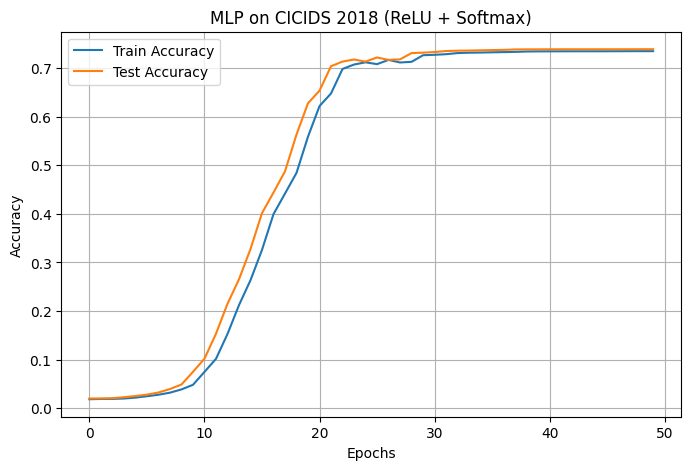

In [ ]:
import matplotlib.pyplot as plt

# Training function
def train(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.01):
    history = {"train_acc": [], "test_acc": []}

    for epoch in range(epochs):
        # forward
        a_h, a_out = model.forward(X_train)

        # backward
        d_w_out, d_b_out, d_w_h, d_b_h = model.backward(X_train, a_h, a_out, y_train)

        # update weights
        model.weight_out -= lr * d_w_out
        model.bias_out -= lr * d_b_out
        model.weight_h -= lr * d_w_h
        model.bias_h -= lr * d_b_h

        # train acc
        train_preds = np.argmax(a_out, axis=1)
        train_acc = np.mean(train_preds == y_train)

        # test acc
        _, test_out = model.forward(X_test)
        test_preds = np.argmax(test_out, axis=1)
        test_acc = np.mean(test_preds == y_test)

        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return history


# Train model

num_features = X_train.shape[1]
num_classes = len(np.unique(y))
model = NeuralNetMLP(num_features=num_features, num_hidden=64, num_classes=num_classes)

history = train(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.01)


# Plot accuracy curves

plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["test_acc"], label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MLP on CICIDS 2018 (ReLU + Softmax)")
plt.legend()
plt.grid(True)
plt.show()


# **OBSERVATION **



*   Training and testing accuracy started very low (~2%) but gradually improved.

*   By epoch 20, the test accuracy reached around 62%, and by epoch 30–50, the accuracy stabilized around 73–74%.

*   The final accuracy after 50 epochs was Train Accuracy = 73.5% and Test    Accuracy = 73.9%.










*   The accuracy curves show a steady rise in both training and testing performance, indicating that the network successfully learned useful patterns from the data.

*   Training and testing curves remained close together, suggesting that the model is not overfitting heavily. Instead, it generalizes reasonably well to unseen data.




The applied MLP achieved ~74% accuracy on CICIDS 2018, which demonstrates its ability to detect and classify different types of network traffic.